In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [4]:
df = pd.read_csv('E:\OneDrive\Desktop\TCS_stock_history.csv')  # Replace with your path
print(df.head())

         Date       Open       High        Low      Close  Volume  Dividends  \
0  2002-08-12  28.794172  29.742206  28.794172  29.519140  212976        0.0   
1  2002-08-13  29.556316  30.030333  28.905705  29.119476  153576        0.0   
2  2002-08-14  29.184536  29.184536  26.563503  27.111877  822776        0.0   
3  2002-08-15  27.111877  27.111877  27.111877  27.111877       0        0.0   
4  2002-08-16  26.972458  28.255089  26.582090  27.046812  811856        0.0   

   Stock Splits  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

for col in ['Open','High','Low','Close','Volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.fillna(method='ffill', inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4463 entries, 0 to 4462
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          4463 non-null   datetime64[ns]
 1   Open          4463 non-null   float64       
 2   High          4463 non-null   float64       
 3   Low           4463 non-null   float64       
 4   Close         4463 non-null   float64       
 5   Volume        4463 non-null   int64         
 6   Dividends     4463 non-null   float64       
 7   Stock Splits  4463 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 279.1 KB
None


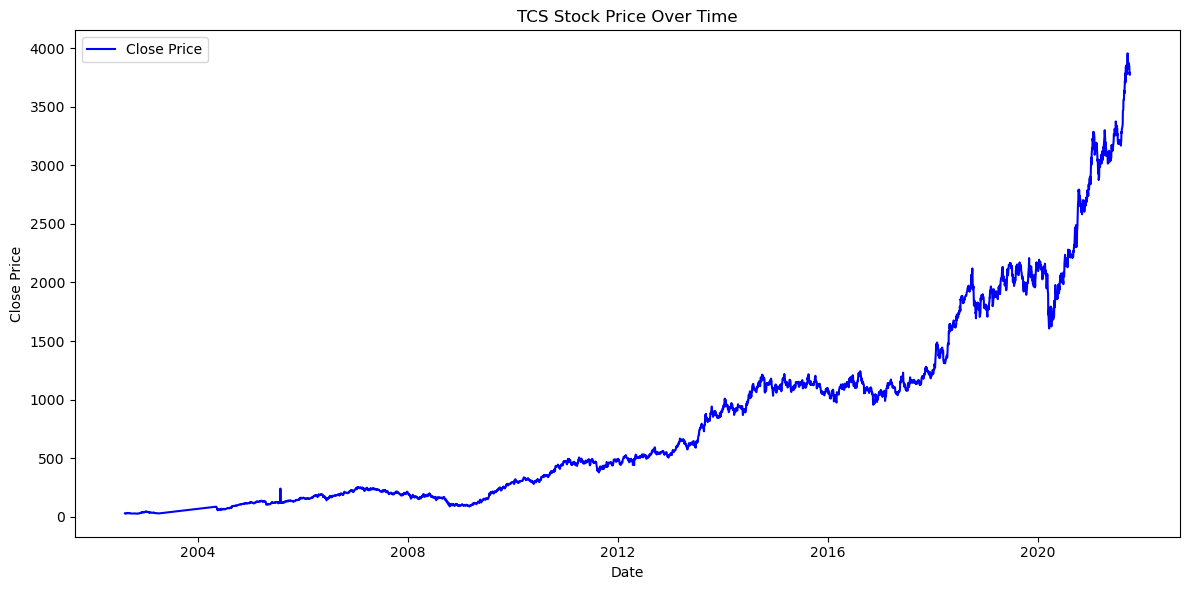

In [6]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='b')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('TCS Stock Price Over Time')
plt.legend()
plt.tight_layout()
plt.show()

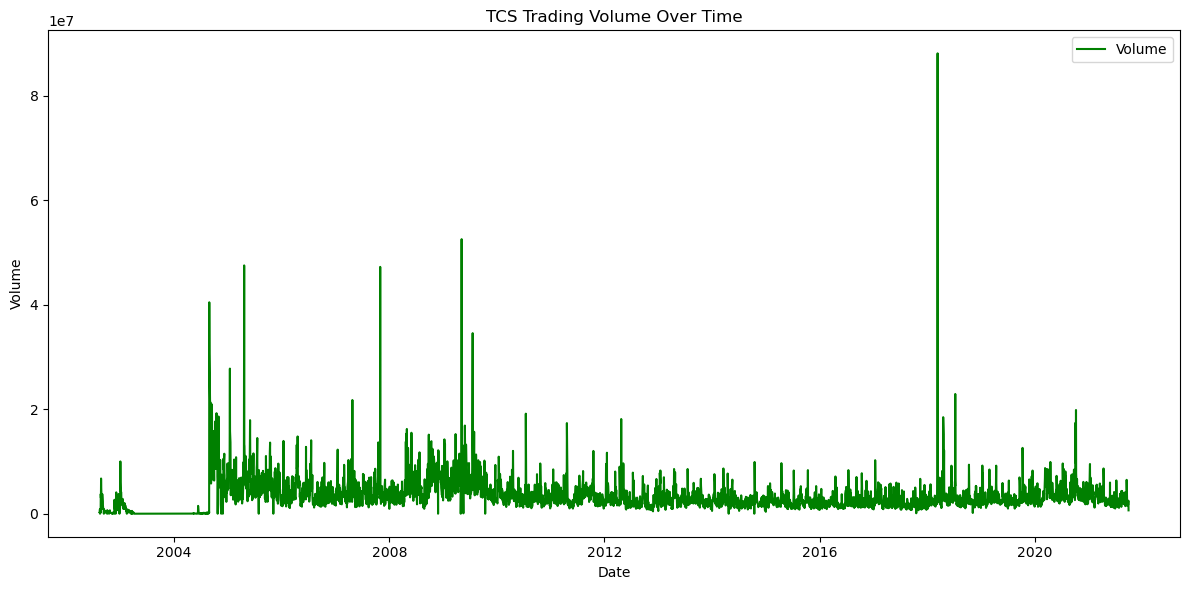

In [7]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Volume'], label='Volume', color='g')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('TCS Trading Volume Over Time')
plt.legend()
plt.tight_layout()
plt.show()

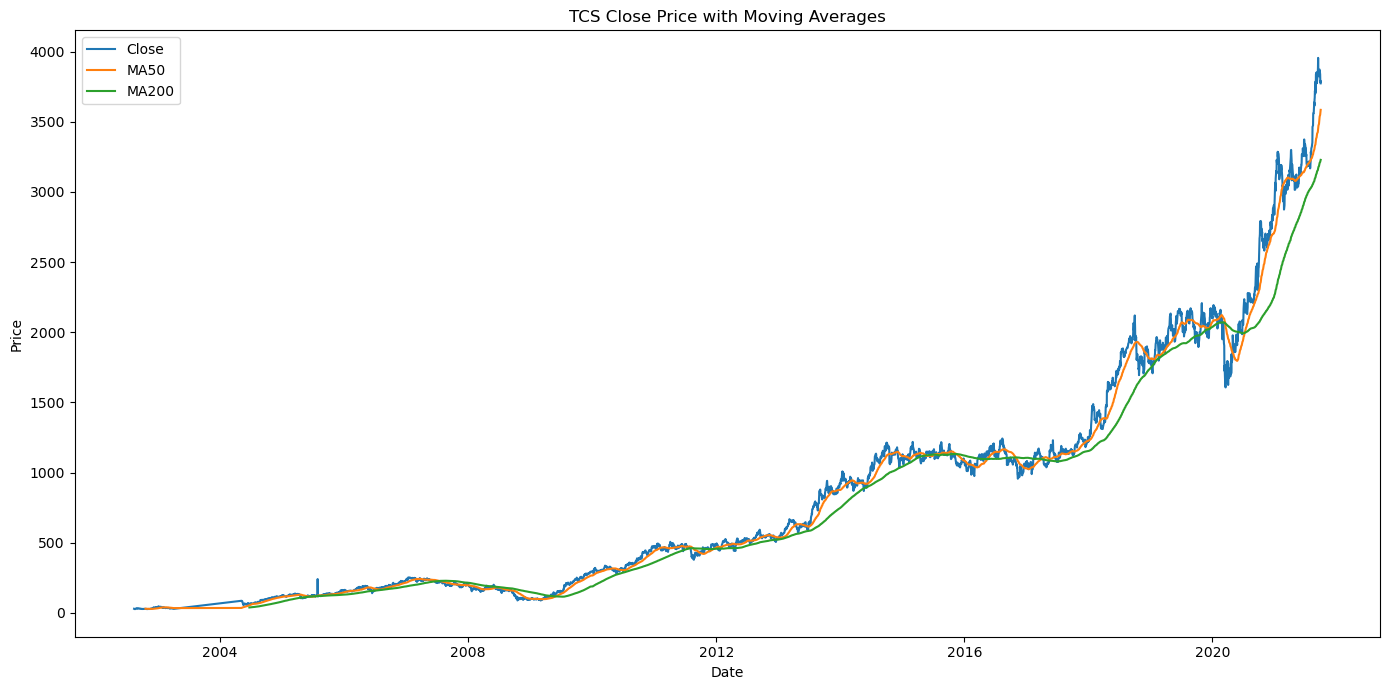

In [8]:
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()
plt.figure(figsize=(14,7))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['MA50'], label='MA50')
plt.plot(df['Date'], df['MA200'], label='MA200')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('TCS Close Price with Moving Averages')
plt.legend()
plt.tight_layout()
plt.show()

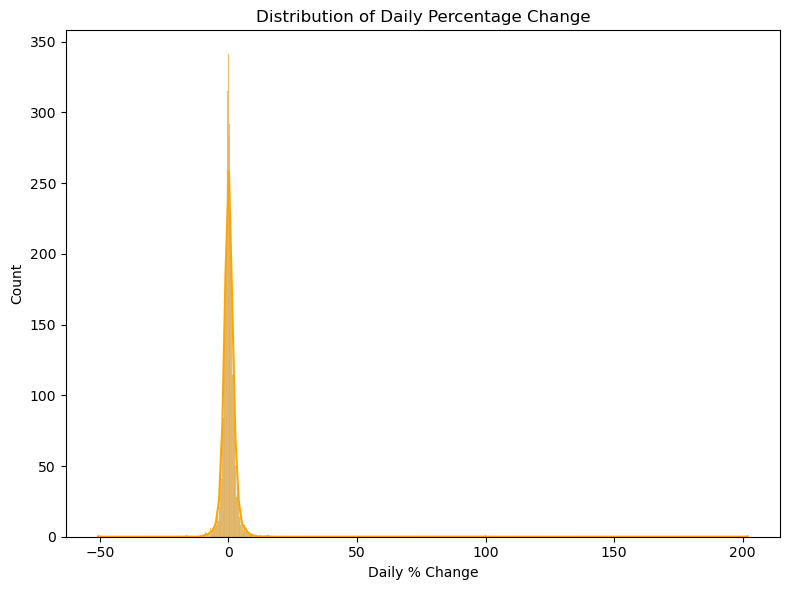

In [9]:
df['Daily_Change'] = df['Close'].pct_change()*100
plt.figure(figsize=(8,6))
sns.histplot(df['Daily_Change'].dropna(), kde=True, color='orange')
plt.xlabel('Daily % Change')
plt.title('Distribution of Daily Percentage Change')
plt.tight_layout()
plt.show()

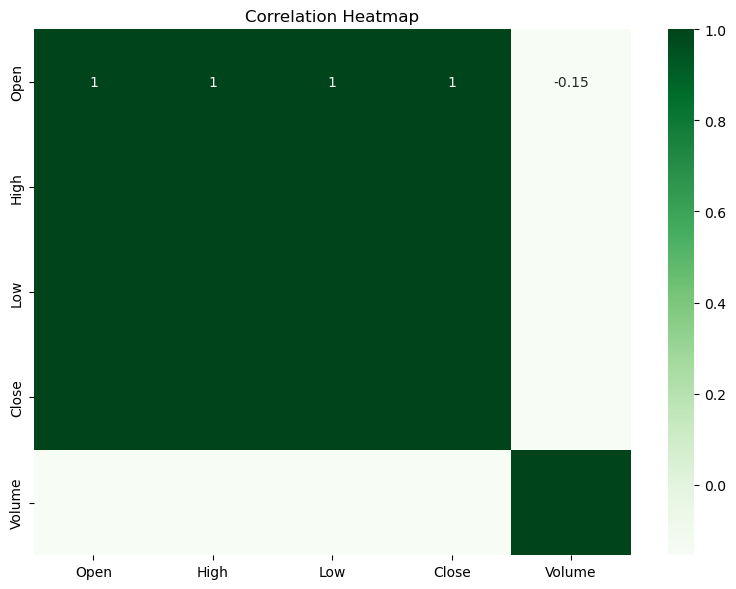

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['Open','High','Low','Close','Volume']].corr(), annot=True, cmap='Greens')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [11]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Prev_Close'] = df['Close'].shift(1)
df['MA7'] = df['Close'].rolling(window=7).mean()
df = df.dropna().reset_index(drop=True)

In [12]:
features = ['Open', 'High', 'Low', 'Volume', 'Prev_Close', 'Day_of_Week', 'Month', 'MA7']
X = df[features]
y = df['Close']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [14]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("Linear Regression Results:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_lr))
print("R2 Score:", r2_score(y_test, y_pred_lr))

Linear Regression Results:
Mean Squared Error: 209.45695110920545
R2 Score: 0.999371974318723


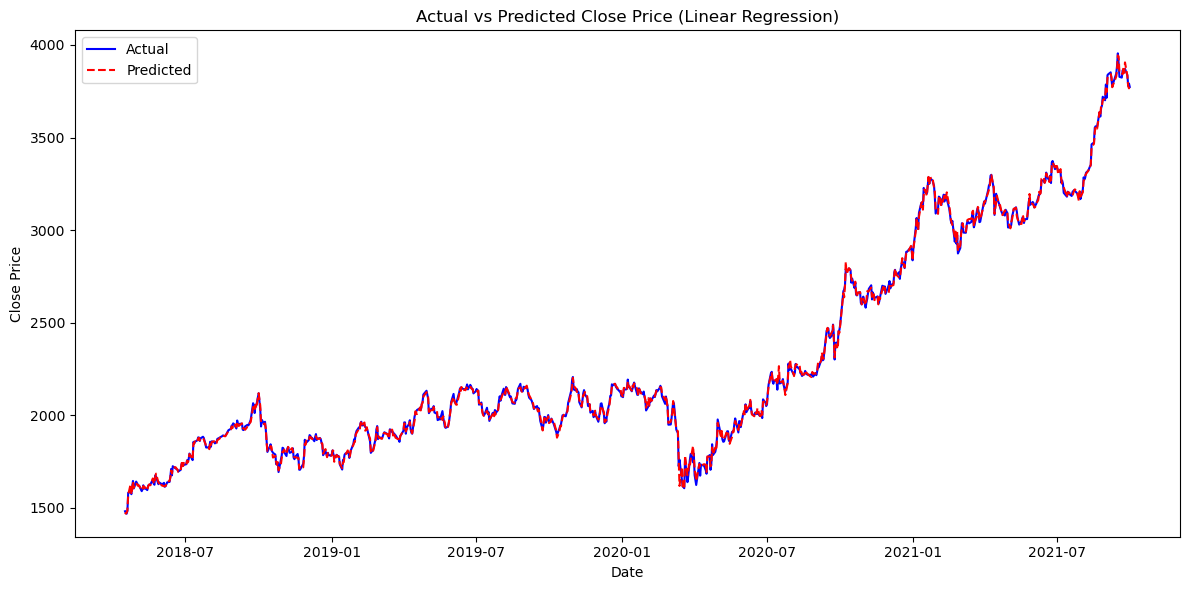

In [15]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'].iloc[-len(y_test):], y_test.values, label='Actual', color='b')
plt.plot(df['Date'].iloc[-len(y_test):], y_pred_lr, label='Predicted', color='r', linestyle='--')
plt.title('Actual vs Predicted Close Price (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
print("\nProceeding to advanced LSTM modeling (optional, requires keras/tensorflow).")
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

close_prices = df['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0,1))
close_scaled = scaler.fit_transform(close_prices)


Proceeding to advanced LSTM modeling (optional, requires keras/tensorflow).


In [17]:
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)


In [18]:
look_back = 60 
X_lstm, y_lstm = create_dataset(close_scaled, look_back)
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))

split = int(0.8 * len(X_lstm))
X_train_lstm, y_train_lstm = X_lstm[:split], y_lstm[:split]
X_test_lstm, y_test_lstm = X_lstm[split:], y_lstm[split:]

In [19]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

lstm_model.fit(X_train_lstm, y_train_lstm, epochs=25, batch_size=32, verbose=1)


lstm_preds = lstm_model.predict(X_test_lstm)
lstm_preds_actual = scaler.inverse_transform(lstm_preds)
y_test_actual = scaler.inverse_transform(y_test_lstm.reshape(-1,1))

Epoch 1/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - loss: 0.0037
Epoch 2/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 4.2314e-05
Epoch 3/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 5.2618e-05
Epoch 4/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 3.9536e-05
Epoch 5/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 4.3297e-05
Epoch 6/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 3.9921e-05
Epoch 7/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 4.0679e-05
Epoch 8/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 4.4495e-05
Epoch 9/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 5.5669e-05
Epoch 10/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 3.1953e-05
Epoch 11/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 3.1165e-05
Epoch 12/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 3.3959e-05
Epoch 13/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 2.9219e-05
Epoch 14/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 

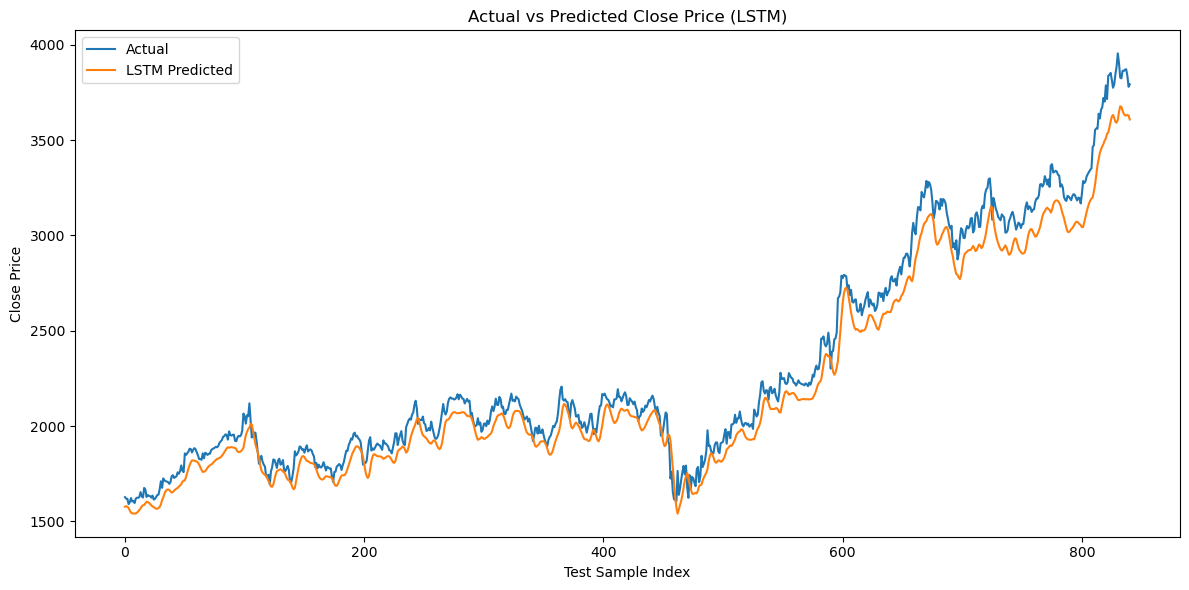

LSTM Mean Absolute Error: 96.58126181512894


In [20]:
plt.figure(figsize=(12,6))
plt.plot(range(len(y_test_actual)), y_test_actual, label='Actual')
plt.plot(range(len(lstm_preds_actual)), lstm_preds_actual, label='LSTM Predicted')
plt.title('Actual vs Predicted Close Price (LSTM)')
plt.xlabel('Test Sample Index')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

print("LSTM Mean Absolute Error:", mean_absolute_error(y_test_actual, lstm_preds_actual))

In [21]:
feature_imp = pd.Series(lr_model.coef_, index=features)
print("\nFeature Importances (Linear Regression):")
print(feature_imp)


Feature Importances (Linear Regression):
Open          -4.345169e-01
High           7.899188e-01
Low            6.996103e-01
Volume        -4.109030e-08
Prev_Close    -6.789127e-02
Day_of_Week    4.384866e-02
Month         -1.509795e-02
MA7            1.183135e-02
dtype: float64
